In [12]:
import re
import abc
import fileinput
import itertools
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import scipy.optimize as opt
from functools import partial
from natsort import natsorted
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt
from functools import cached_property
from dataclasses import dataclass, field
from scipy.ndimage import gaussian_filter

In [13]:
'''
Conventions:
Variabelnames:
    high-dimensional-arrays:
        - each axis is in the variable name
        - each axis is separated by an underscore (dimensionality is #underscores+1)
        - each axis name's first letter is capitalised and they should be plural (even if dim == 1)
        - the axes might be followed by a descriptor for the elememt's content which should be singular
        - for variables, underscores are reserved for high-dimensional-arrays with a few exceptions:
            * units that would look totally ugly without an underscore between the constant (kB_kcalmolK | kBkcalmolK)
        - Examples:
            * axis0_axis1_axis2 -> Hamiltonians_CollectiveVariables_Timeseries
            * axis0_axis1Property -> Hamiltonians_CollectiveVariablesSamplesize
'''

"\nConventions:\nVariabelnames:\n    high-dimensional-arrays:\n        - each axis is in the variable name\n        - each axis is separated by an underscore (dimensionality is #underscores+1)\n        - each axis name's first letter is capitalised and they should be plural (even if dim == 1)\n        - the axes might be followed by a descriptor for the elememt's content which should be singular\n        - for variables, underscores are reserved for high-dimensional-arrays with a few exceptions:\n            * units that would look totally ugly without an underscore between the constant (kB_kcalmolK | kBkcalmolK)\n        - Examples:\n            * axis0_axis1_axis2 -> Hamiltonians_CollectiveVariables_Timeseries\n            * axis0_axis1Property -> Hamiltonians_CollectiveVariablesSamplesize\n"

In [14]:
!python --version

Python 3.11.6


In [15]:
class FileParser(ABC):
    def __init__(self, files, CollectiveVariableColumns, subset=0):
        self.files: list[str] = files
        self.CVColumns: list[int] = CollectiveVariableColumns
        self.verbose: bool = False
        self.subset: int = (-subset)
        self.__post_init__()
        
    @abstractmethod
    def __post_init__(self):
        '''initialise subclass attributes'''
    
    @abstractmethod
    def parse_anchors(self) -> np.ndarray:
        '''abstract method to obtain force constant and anchor information form simulation output files'''
        
    @abstractmethod
    def parse_force_constants(self) -> np.ndarray:
        '''do stuff'''
        
    @abstractmethod
    def parse_collective_variables(self) -> list[np.ndarray]:
        '''abstract method to obtain raw data from simulation output''' 

    def calculateSamplesize(self) -> list[int]:
        pass
    
    
class AMBER_PMD_Parser(FileParser):
    def __post_init__(self):
        self.columnPattern: str = r'anchor\({}\)'
        self.anchorRegex: re.Pattern = re.compile(r'position = .?\d*.\d+,\s+(.?\d*.\d*),\s+(.?\d*.\d+),\s+.?\d*.\d+')
        self.forceConstantRegex: re.Pattern = re.compile(r'strength = (\d*.\d+),\s+(\d*.\d*)')
        ### this one should not be accessible from init try later first solve the samplesizes problem and the initialisation of the decorrelation engine
        self.forceConstantCorrectionFactor: float = 0.5

    def parse_anchors(self) -> np.ndarray:
        def search_anchor_in_line(file,CVcolumn):
            self.columnRegex = re.compile(self.columnPattern.format(CVcolumn))
            with open(file) as fileContent:
                    for line in fileContent:
                        match = re.search(self.columnRegex, line)
                        if match: 
                            anchor1, anchor2 = re.search(self.anchorRegex, line).group(1,2)
                            assert anchor1 == anchor2, "It seems, that your minimum is not defined as a point. Only harmonic potentials are implemented"
                            return float(anchor1)
        
        def loop_through_files_and_columns():
            anchors = []
            for file in self.files:
                anchors.append([search_anchor_in_line(file,CVcolumn) for CVcolumn in self.CVColumns])
            return anchors
        
        anchors = loop_through_files_and_columns()
        anchors = np.array(anchors).reshape(-1, len(self.CVColumns))
        return(anchors)
        
    def parse_force_constants(self) -> np.ndarray:
        def search_forceConstants_in_line(file,CVcolumn):
            self.columnRegex = re.compile(self.columnPattern.format(CVcolumn))
            with open(file) as fileContent:
                    for line in fileContent:
                        match = re.search(self.columnRegex, line)
                        if match: 
                            forceConstant1, forceConstant2 = re.search(self.forceConstantRegex, next(fileContent)).group(1,2)
                            assert forceConstant1 == forceConstant2, "It seems, that the steepness of your potential is asymmetric. Only harmonic potentials are implemented"
                            return float(forceConstant1)
        
        def loop_through_files_and_columns():
            forceConstants = []
            for file in self.files:
                forceConstants.append([search_forceConstants_in_line(file,CVcolumn) for CVcolumn in self.CVColumns])
            return forceConstants
            
        forceConstants = loop_through_files_and_columns()
        forceConstants = np.array(forceConstants).reshape(-1, len(self.CVColumns))
        return(forceConstants * self.forceConstantCorrectionFactor)
    
    
    def parse_collective_variables(self) -> list[np.ndarray]:
        CollectiveVariablesList = []
        for file in (tqdm(self.files) if self.verbose else self.files):
            
            CollectiveVariablesDF = pd.read_csv(file,delim_whitespace=True,comment='#',header=None,usecols=self.CVColumns)
            CollectiveVariablesList.append(CollectiveVariablesDF.values[self.subset:].T)
                 
        Hamiltonians_CollectiveVariables_Timeseries = np.column_stack(list(itertools.zip_longest(CollectiveVariablesList, fillvalue=0)))
        Hamiltonians_CollectiveVariables_Timeseries[~np.isfinite(Hamiltonians_CollectiveVariables_Timeseries)] = 0
        Hamiltonians_CollectiveVariables_Timeseries = Hamiltonians_CollectiveVariables_Timeseries.reshape(len(self.files), len(self.CVColumns), -1)
        return Hamiltonians_CollectiveVariables_Timeseries

In [16]:
@dataclass(slots=True)
class DataMaster(ABC):
    @property
    def hamiltonians() -> np.ndarray[int]:
        '''hamiltonian indices of the simulation'''

@dataclass(slots=True)
class CorrelationTimeEstimator(ABC):
    FE_DataVault: DataMaster
    
    @abstractmethod
    def estimate_correlation_times():
        '''some fancy algorithm to estimate the correlation time'''

@dataclass(slots=True)
class DecorrelationEngine(ABC):
    CTE: CorrelationTimeEstimator
    safetyFactor: float

    @abstractmethod
    def correlationTimes() -> np.ndarray[float]:
        '''Property that should be calculated with the aid of CTE'''
    
    @abstractmethod
    def subsamplingIndexList() -> None:
        '''The subsampling index array is calculated and cached.'''
    
    @property
    def decorrelatedSamplesizes(self) -> np.ndarray[int]:
        '''Property that contains the reduced samplesizes using the correlation time'''
    
    @abstractmethod
    def decorrelate_collective_variables() -> np.ndarray:
        '''collective Variables are being decorrelated using the subsampled index arrays'''

@dataclass(slots=True)
class FE_DataVault(DataMaster):
    kB_kcalmolK: float = 0.001987204259
    temperatureK: np.ndarray[float] = field(default_factory=lambda: np.array([300]))
    Anchors: np.ndarray = field(init=False)
    ForceConstants: np.ndarray = field(init=False)
    Hamiltonians_CollectiveVariables_Timeseries: list[np.ndarray] = field(init=False)
    Hamiltonians_CollectiveVariablesSamplesize: np.ndarray = field(init=False)
    isDecorrelated: bool = False
    
    ### I think hamiltonians and CVCOlumns in Decorellation engine should be here and 
    ### correlationTimeEstimator should receive the whole FE_DataVault
    ### although, then the FE_DataVault is arg of CTE which is arg of CorrEng which alters values in FE_DataVault
    ### might be suboptimal...
    ### but no. I can make a method that is callable from the CorrEng for the FE_DataVault that does the
    ### subsampling ad hoc within the decorrelation engine... which is its responsibility. 
    ### then the data container would be just containing the data...hm.
    @property
    def hamiltonians(self) -> np.ndarray[int]:
        return np.arange(self.Hamiltonians_CollectiveVariables_Timeseries.shape[0])
    @property
    def CVColumns(self) -> np.ndarray[int]:
        return np.arange(self.Hamiltonians_CollectiveVariables_Timeseries.shape[1])
    @property
    def betaFactor(self) -> np.ndarray[float]:
        return 1 / (self.kB_kcalmolK * self.temperatureK)
    
    def ParseData(self, file_parser: FileParser) -> None:
        def samplesizes_from_collective_variables():
            samplesizes = [ts[ts!=0].shape[0] for CV_ts in self.Hamiltonians_CollectiveVariables_Timeseries for ts in CV_ts]
            samplesizes = np.array(samplesizes).reshape(self.Hamiltonians_CollectiveVariables_Timeseries.shape[:-1])
            return samplesizes
        self.Anchors = file_parser.parse_anchors()
        self.ForceConstants = file_parser.parse_force_constants()
        self.Hamiltonians_CollectiveVariables_Timeseries = file_parser.parse_collective_variables()
        self.Hamiltonians_CollectiveVariablesSamplesize = samplesizes_from_collective_variables()
        
    def DecorrelateData(self, decor_engine: DecorrelationEngine) -> None:
        if self.isDecorrelated:
            print("Data is already decorrelated. Manually set <FE_DataVault>.isDecorrelated to 'False'")
            return
        ### next prepare_subsamplearray blabla! 
        self.Hamiltonians_CollectiveVariablesSamplesize = DecorrelationEngine.decorrelatedSamplesizes
        self.Hamiltonians_CollectiveVariables_Timeseries = DecorrelationEngine.decorrelate_collective_variables()


In [17]:
def logistic(x, a, k):
    return a / (1. + np.exp(-k * (x - 1))) - 0.5 * a

def d2logistic_dx2(x, a, k):
    return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3

In [18]:
@dataclass(slots=True)
class CorrelationTimeFromBSE(CorrelationTimeEstimator):
    minSamplesize: int
    logisticAmplitudes: np.ndarray[float] = field(init=False)
    logisticGrowthRates: np.ndarray[float] = field(init=False)
    
    @property
    def maxBlockSize(self) -> int:
        return np.round(self.FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize / self.minSamplesize).astype(int)
    @property
    def blockSizes(self) -> np.ndarray[int]:
        blocksizes = np.array([np.arange(self.maxBlockSize[hamiltonian,CVColumn])+1 for hamiltonian, CVColumn in itertools.product(self.FE_DataVault.hamiltonians, self.FE_DataVault.CVColumns)])
        return blocksizes.reshape(*self.FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize.shape, -1)
    @property    
    def BSE_curves(self) -> list[np.ndarray]:
        return [np.fromiter(map(partial(self.compute_BSE,
                                        self.FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize[i,j],
                                        self.FE_DataVault.Hamiltonians_CollectiveVariables_Timeseries[i,j]),
                                self.blockSizes[i,j]), dtype=float) for i,j in itertools.product(self.FE_DataVault.hamiltonians, self.FE_DataVault.CVColumns)]
    @property
    def logisticInflictionPoints(self) -> np.ndarray[int]:
        logisticFit2ndDerivative = d2logistic_dx2(self.blockSizes.squeeze(),
                       self.logisticAmplitudes[:,None],
                       self.logisticGrowthRates[:,None])
        return np.argmin(logisticFit2ndDerivative, axis=1) + 1

    def fit_logistic_to_BSE(self):
        logistic_fit = partial(opt.curve_fit, logistic)
        (self.logisticAmplitudes, self.logisticGrowthRates) = np.array([logistic_fit(np.arange(BSE.size)+1, BSE)[0] for BSE in self.BSE_curves], dtype=np.float128).T

    def compute_BSE(self, samplesize: np.ndarray[int], timeseries: np.ndarray[int], blockSize: int) -> np.ndarray[float]:
        skip = samplesize % blockSize
        blockedAverages = np.mean(timeseries[skip:].reshape(-1, blockSize), axis=0)
        blockedStandardError = np.std(blockedAverages)
        return blockedStandardError / np.sqrt(blockSize)
        
    def estimate_correlation_times(self) -> np.ndarray[int]:
        self.fit_logistic_to_BSE()
        return self.logisticInflictionPoints.reshape(*self.FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize.shape)

In [19]:
def show_BSE_estimator_plot(blocksizes: np.ndarray[int],
                            BSE_curves: list[np.ndarray],
                            amplitudes: np.ndarray[float],
                            growthrates: np.ndarray[float],
                            hamiltonians: np.ndarray[int],
                            CVColumns: np.ndarray[int],
                            plotFilePath: bool = False) -> None:
    logisticFit = logistic(blocksizes.squeeze(), amplitudes[:,None], growthrates[:,None])
    logisticFit2ndDerivative = d2logistic_dx2(blocksizes.squeeze(), amplitudes[:,None],growthrates[:,None])
    logisticInflictionPoints = np.argmin(logisticFit2ndDerivative, axis=1) + 1
    
    for i,(hamiltonian,CVColumn) in enumerate(itertools.product(hamiltonians,CVColumns)):
        blocksize = blocksizes.squeeze()[i]
        gaussian_smooth = gaussian_filter(BSE_curves[i], sigma=10)
        fig, ax = plt.subplots(1, 1, figsize=(8, 2))
        ax2 = ax.twinx()
        
        BSEGraph = (blocksize, BSE_curves[i])
        SmoothGraph = (blocksize, gaussian_smooth)
        logisticGraph = (blocksize, logisticFit[i])
        DerivativeGraph = (blocksize, logisticFit2ndDerivative[i])
        
        BSEPlot = ax.plot(*BSEGraph, alpha=0.7, label='data')
        SmoothPlot = ax.plot(*SmoothGraph, linestyle='--', linewidth=0.7, label='gaussian smooth')
        logisticPlot = ax.plot(*logisticGraph, label='logistic fit')
        DerivativePlot = ax2.plot(*DerivativeGraph, linestyle='-.', label='2nd derivative')
        InflictionLine = ax.axvline(logisticInflictionPoints[i], linewidth=0.5, color='r', label='t_corr')

        plots = BSEPlot+SmoothPlot+logisticPlot+DerivativePlot
        labels = [plot.get_label() for plot in plots]
        ax.set_title('BSE analysis for hamiltonian {} Column {} (t_corr={})'.format(hamiltonian,CVColumn,logisticInflictionPoints[i]))
        ax.legend(plots, labels)
        if plotFilePath: plt.savefig(plotFilePath)
        plt.show()

In [20]:
# def main():
files = natsorted(glob('../_sim/13*/_output/pmd_p*[!a].txt'))

parser = AMBER_PMD_Parser(files, [5])

dG_oS_FE_DataVault = FE_DataVault()
dG_oS_FE_DataVault.ParseData(parser)

In [21]:
BSE_estimator = CorrelationTimeFromBSE(dG_oS_FE_DataVault,
                                       1000)
BSE_estimator.estimate_correlation_times()

array([[12],
       [ 2]])

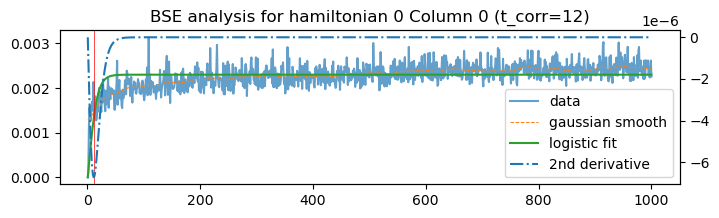

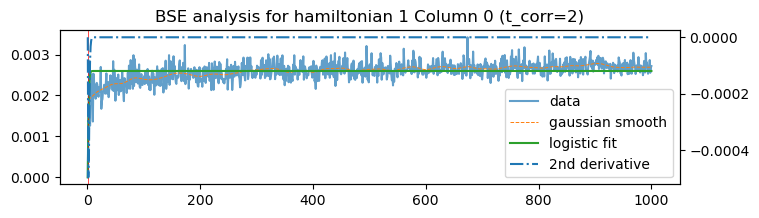

In [12]:
show_BSE_estimator_plot(BSE_estimator.blockSizes,
                        BSE_estimator.BSE_curves,
                        BSE_estimator.logisticAmplitudes,
                        BSE_estimator.logisticGrowthRates,
                        dG_oS_FE_DataVault.hamiltonians,
                        dG_oS_FE_DataVault.CVColumns)

In [22]:
### muss komplett geaendert werden
@dataclass(slots=True)
class BSEDecorrelator(DecorrelationEngine):
    ### maybe also give the FE_DataVault as an argument
    @property
    def correlationTimes(self) -> np.ndarray[float]:
        return self.CTE.estimate_correlation_times() * self.safetyFactor
    
    @property
    def decorrelatedSamplesizes(self) -> np.ndarray[int]:
        return (self.CTE.FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize / self.correlationTimes).astype(int)
    
    def decorrelate_collective_variables(self) -> np.ndarray:
        print("make subsampling array with exact same shape as H_Cv_ts")
        # make index array
        # shuffle index array
        # sort first N elements
        indices = random_subsampling(self.CTE.FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize[h,c]
                                     self.decorrelatedSamplesizes[h,c])
        print("return H_Cv_Ts indexed with the subsampling array")
        # index the larger H_Cv_Ts array
        H_Cv_Ts[:self.decorrelatedSamplesizes[h,c]] = self.CTE.FE_DataVault.Hamiltonians_CollectiveVariables_Timeseries[h,c,decorrelated
        ### I left of here.

SyntaxError: invalid syntax. Perhaps you forgot a comma? (568866477.py, line 18)

In [57]:
indexArray = np.zeros(dG_oS_FE_DataVault.Hamiltonians_CollectiveVariables_Timeseries.shape)

for i,j in itertools.product(dG_oS_FE_DataVault.hamiltonians, dG_oS_FE_DataVault.CVColumns):
    indexArray[i,j,:] = np.arange(indexArray.shape[-1])
    samplesize = dG_oS_FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize[i,j]
    decorrelatedSamplesize = samplesize / decorrelationtimes[i,j]
    indexArray[i,j,:samplesize] = random_subsampling(samplesize, decorrelatedSamplesize)
    boom. done!! :) maybe...

(2, 1, 5)

In [56]:
def random_subsampling(samplesize, decorrelatedSamplesize) -> np.ndarray[int]:
    ids = np.random.permutation(samplesize)
    ids[:decorrelatedSamplesize] = np.sort(ids[:decorrelatedSamplesize])

In [62]:
dG_oS_FE_DataVault.Hamiltonians_CollectiveVariables_Timeseries[[1],[0],,]

array([-3.00036235, -3.05729131, -3.03175338, -3.04484273])

In [43]:
dG_oS_FE_DataVault.Hamiltonians_CollectiveVariables_Timeseries[np.array([[0,1,2,3,4,5,6,7]])].shape

IndexError: index 2 is out of bounds for axis 0 with size 2

In [25]:
CVCount = dG_oS_FE_DataVault.Hamiltonians_CollectiveVariables_Timeseries.shape[-1]
CVColumns = dG_oS_FE_DataVault.CVColumns.size
hamiltonians = dG_oS_FE_DataVault.hamiltonians.size

CVIndices = np.arange(CVCount)
indexArray = np.tile(CVIndices, (hamiltonians, CVColumns))

In [103]:
ids = np.random.permutation(dG_oS_FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize[0,0])
ids[:dG_oS_decorrelator.decorrelatedSamplesizes[0,0]] = np.sort(ids[:dG_oS_decorrelator.decorrelatedSamplesizes[0,0]])
ids

array([   118,    143,    190, ..., 465372, 777196, 572594])

In [91]:
np.arange(dG_oS_decorrelator.decorrelatedSamplesizes[0,0])

array([    0,     1,     2, ..., 41663, 41664, 41665])

In [98]:
dG_oS_decorrelator = BSEDecorrelator(BSE_estimator, 2.0)
dG_oS_decorrelator.subsamplingIndexList[0]

[array([    26,     35,     40, ...,  71808, 681120, 389156]),
 array([    12,     13,     15, ..., 266071, 492804, 576040])]

In [100]:
dG_oS_decorrelator.subsamplingIndexList[0].shape

(1000000,)

In [77]:
dG_oS_FE_DataVault.Hamiltonians_CollectiveVariablesSamplesize.

array([1000000, 1000000])

In [60]:
dG_oS_decorrelator.subsamplingIndexArray

AttributeError: 'CorrelationTimeFromBSE' object has no attribute 'Hamiltonians_CollectiveVariablesSamplesize'

In [147]:
BSE_estimator.estimate_correlation_time()

array([[12],
       [ 2]])